In [53]:
from IPython.display import display
import numpy as np
# import modin.pandas as pd
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE, f_regression

import warnings
warnings.filterwarnings('ignore')

plt.style.use("fivethirtyeight")
sns.set_style({'font.sans-serif': ['simsun', 'Arial']})
sns.set_style('darkgrid', {'font.sans-serif': ['simhei', 'Arial']})
%matplotlib inline

# np.random.seed(4590)
nf_data_path = r'../../Data/noFinacialFeatures.csv'
f_data_path = r'../../Data/FinacialFeatures.csv'
flevel = json.load(open(r'../FeatureEngineering/feature_level.json'))

In [61]:
nf_df = pd.read_csv(nf_data_path)
f_df = pd.read_csv(f_data_path)

In [62]:
df = pd.DataFrame()
df = nf_df.copy()

f_df.drop(['企业总评分'], axis=1, inplace=True)
df = df.merge(f_df, how='left', on='企业编号')
first_level = flevel['first_level']
first_level.append('企业编号')
first_level.append('企业总评分')
df = df[first_level]
df.head(5)

,资产:流动资产合计(元)_mean,资产:流动资产合计(元)_max,资产:流动资产合计(元)_min,资产:流动资产合计(元)_std,资产:流动资产合计(元)滚动增长_mean,资产:资产总计(元)_mean,资产:资产总计(元)_max,资产:资产总计(元)_min,资产:资产总计(元)_std,资产:资产总计(元)滚动增长_mean,...,票面利率（%）_max,票面利率（%）_min,计划发行总额（亿元）_sum,计划发行总额（亿元）_max,计划发行总额（亿元）_min,城镇职工基本养老保险人数,保险实缴/人数,基数/人数,企业编号,企业总评分
0,37.138558,102.982866,-3.422013,45.402146,0.526979,5.236450,10.129814,0.418085,3.678978,1.536082,...,0.00,0.00,0.0,0.0,0.0,2176,17910.412479,43390.918022,1001,75.374276
1,53.649848,102.805115,-40.517576,70.738587,-0.250285,28.653568,44.691555,16.642118,10.948562,-0.128498,...,4.35,3.05,38.0,10.0,3.0,2176,17910.412479,43390.918022,1002,79.830122
2,-0.078404,23.757798,-18.510366,16.111779,-2.589393,-9.319352,15.939361,-24.609220,17.478754,-0.527514,...,0.00,0.00,0.0,0.0,0.0,2176,17910.412479,43390.918022,1003,78.318264
3,43.189113,105.787782,1.316974,47.110533,15.573363,2.084637,7.893039,-2.714605,4.968071,-0.395071,...,5.50,3.88,29.0,10.0,4.0,2176,17910.412479,43390.918022,1004,83.253376
4,-8.351909,40.883944,-36.417633,32.154606,-0.489689,26.580415,34.378493,19.680974,5.327993,-0.055689,...,5.30,3.30,70.0,10.0,3.0,2176,17910.412479,43390.918022,1005,83.291493


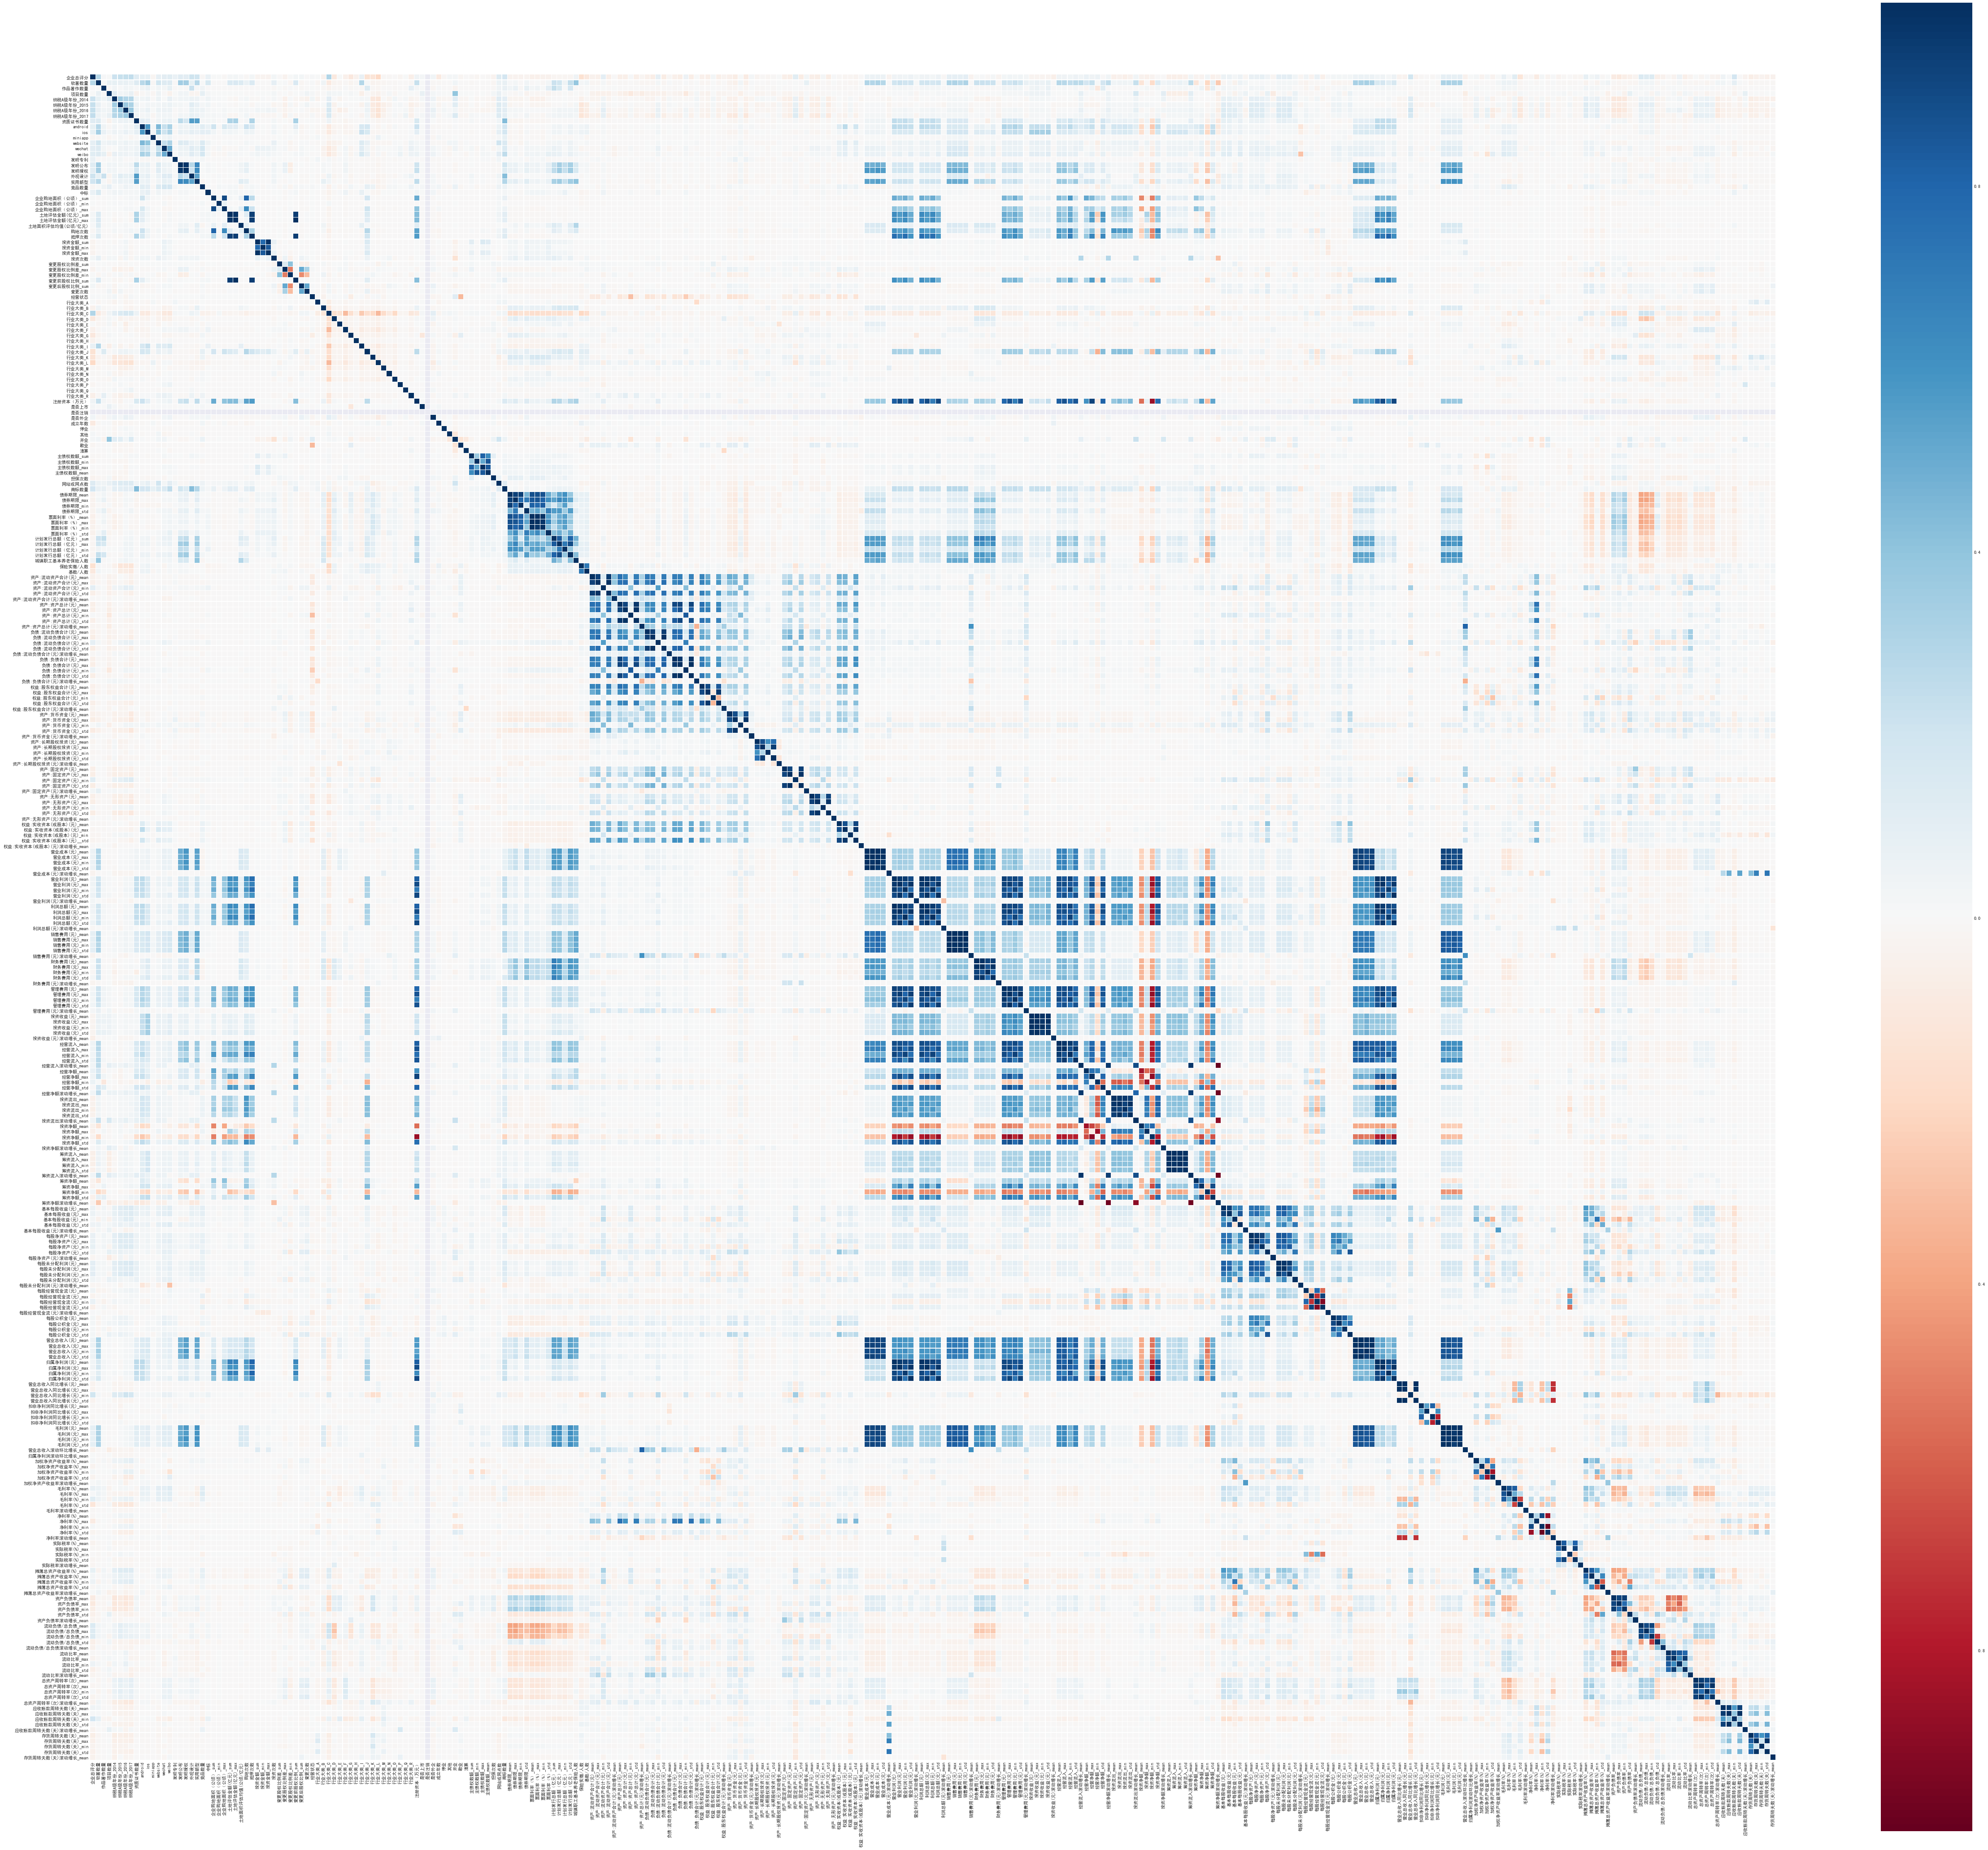

In [4]:
df_d = df.drop(['企业编号'], axis=1)
colormap = plt.cm.RdBu
plt.figure(figsize=(75, 75))
sns.heatmap(df_d.corr(),
            linewidths=0.1,
            vmax=1.0,
            square=True,
            cmap=colormap,
            linecolor='white',
            annot=False)

In [63]:
y = df[['企业编号', '企业总评分']]
x = df.drop(['企业总评分'], axis=1)
xtrain, xtest, ytrain, ytest = train_test_split(
    x, y, test_size=0.2, random_state=0)
ytrain_id = ytrain['企业编号']
ytrain = ytrain['企业总评分']
ytest_id = ytest['企业编号']
ytest = ytest['企业总评分']
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((2364, 205), (592, 205), (2364,), (592,))

In [26]:
xtrain.set_index(np.arange(0, len(xtrain)), inplace=True)
# ytrain.set_index(np.arange(0, len(ytrain)), inplace=True)
xtrain.head(5)

,企业编号,软著数量,作品著作数量,项目数量,纳税A级年份_2014,纳税A级年份_2015,纳税A级年份_2016,纳税A级年份_2017,资质证书数量,android,...,应收账款周转天数(天)_mean,应收账款周转天数(天)_max,应收账款周转天数(天)_min,应收账款周转天数(天)_std,应收账款周转天数(天)滚动增长_mean,存货周转天数(天)_mean,存货周转天数(天)_max,存货周转天数(天)_min,存货周转天数(天)_std,存货周转天数(天)滚动增长_mean
0,2574,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,...,54.442222,81.72,37.76,19.800624,-0.035790,94.313333,175.92,30.22,58.951289,-0.067428
1,1121,0.0,0.0,2.0,2.0,0.0,0.0,0.0,8.0,0.0,...,121.655556,156.98,88.91,17.353128,0.015472,125.791667,221.92,77.28,45.120232,0.005389
2,3745,22.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,96.008889,118.56,42.92,25.293863,-0.027840,2.306667,3.18,1.46,0.655038,0.136693
3,2475,6.0,4.0,2.0,2.0,0.0,0.0,2.0,0.0,0.0,...,142.906111,343.31,10.25,120.287790,0.166476,437.723889,1111.39,113.25,301.697398,0.233617
4,3441,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,70.657778,84.38,65.87,5.571395,0.009875,2466.996667,2753.71,2203.02,175.901682,-0.002600


In [64]:
id_train = xtrain['企业编号']
id_test = xtest['企业编号']
xtrain.drop(['企业编号'], axis=1, inplace=True)
xtest.drop(['企业编号'], axis=1, inplace=True)

In [41]:
# xtrain = (xtrain - xtrain.mean())/xtrain.std(ddof=0)
# xtest = (xtest - xtest.mean())/xtest.std(ddof=0)
# xtrain, xtest

# lightGBM

In [35]:
nfolds = 10
folds = KFold(n_splits=nfolds, shuffle=True, random_state=15)

In [36]:
param = {'num_leaves': 50,
         'min_data_in_leaf': 30,
         'objective': 'regression',
         'max_depth': 6,
         'learning_rate': 0.01,
         "min_child_samples": 100,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}

In [65]:
feature_importance_df = np.zeros((xtrain.shape[1], nfolds))
mvalid = np.zeros(len(xtrain))
mfull = np.zeros(len(xtest))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(xtrain.values, ytrain.values)):
    print('----')
    print("fold n°{}".format(fold_))

    x0, y0 = xtrain.iloc[trn_idx], ytrain.iloc[trn_idx]
    x1, y1 = xtrain.iloc[val_idx], ytrain.iloc[val_idx]

    trn_data = lgb.Dataset(x0, label=y0)
    val_data = lgb.Dataset(x1, label=y1)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets=[trn_data, val_data],
                    verbose_eval=500, early_stopping_rounds=150)
    mvalid[val_idx] = clf.predict(x1, num_iteration=clf.best_iteration)

    feature_importance_df[:, fold_] = clf.feature_importance()

    mfull += clf.predict(xtest,
                         num_iteration=clf.best_iteration) / folds.n_splits

----
fold n°0
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.17313	valid_1's rmse: 2.9824
Early stopping, best iteration is:
[739]	training's rmse: 1.81219	valid_1's rmse: 2.95642
----
fold n°1
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.15136	valid_1's rmse: 3.36817
Early stopping, best iteration is:
[786]	training's rmse: 1.73114	valid_1's rmse: 3.32874
----
fold n°2
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.16425	valid_1's rmse: 3.07753
Early stopping, best iteration is:
[753]	training's rmse: 1.79232	valid_1's rmse: 3.04434
----
fold n°3
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.15498	valid_1's rmse: 3.34947
[1000]	training's rmse: 1.53961	valid_1's rmse: 3.2675
Early stopping, best iteration is:
[1164]	training's rmse: 1.41002	valid_1's rmse: 3.2662
----
fold n°4
Training until validation scores don't impro

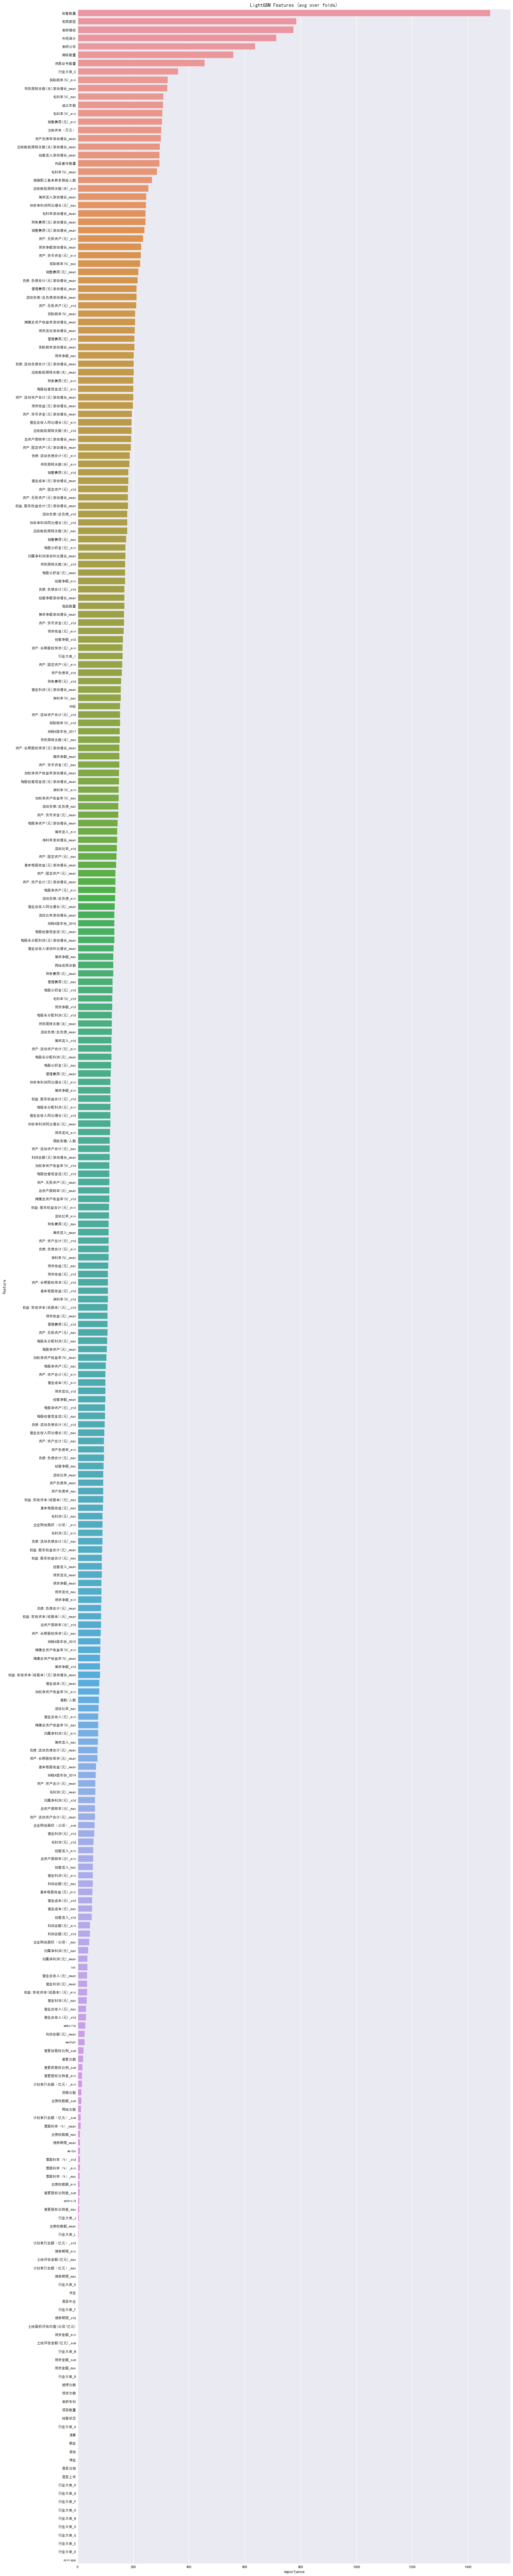

In [39]:
ximp = pd.DataFrame()
ximp['feature'] = xtrain.columns
ximp['importance'] = feature_importance_df.mean(axis=1)

plt.figure(figsize=(20, 100))
sns.barplot(x="importance",
            y="feature",
            data=ximp.sort_values(by="importance",
                                  ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [66]:
np.sqrt(mean_squared_error(mfull.astype(int), ytest.astype(int)))

3.0118011132785556

In [ ]:
# xsub = pd.DataFrame()
# xsub['企业编号'] = id_test
# xsub['企业总评分'] = mfull.astype(int)
# xsub.to_csv('sub_lgb_scaling.csv', index=False)

In [18]:
ranks = {}
colnames = xtrain.columns


def pre_rmse(pre):
    return np.sqrt(mean_squared_error(pre.astype(int), ytest.astype(int)))


def ranking(ranks, names, order=1):
    stand = StandardScaler()
    ranks = stand.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks))

In [8]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=3)
rf.fit(xtrain, ytrain)
ranks["RF"] = ranking(rf.feature_importances_, colnames)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 50building tree 2 of 50building tree 3 of 50

building tree 4 of 50

building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.4s


building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.0s finished


# RFE

In [50]:
# Construct our Linear Regression model
# lr = LinearRegression(normalize=True)
# lr.fit(xtrain, ytrain)
# stop the search when only the last feature is left
# rfe = RFE(lr, n_features_to_select=1, verbose=3)
# rfe.fit(xtrain, ytrain)
# ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

In [55]:
# Using Linear Regression
# lr = LinearRegression(normalize=True)
# lr.fit(xtrain, ytrain)
# ranks["LinReg"] = ranking(np.abs(lr.coef_), colnames)

# Using Ridge
# ridge = Ridge(alpha=7)
# ridge.fit(xtrain, ytrain)
# ranks['Ridge'] = ranking(np.abs(ridge.coef_), colnames)

# Using Lasso
# lasso = Lasso(alpha=.05)
# lasso.fit(xtrain, ytrain)
# ranks["Lasso"] = ranking(np.abs(lasso.coef_), colnames)

# decision tree regression
dtr = DecisionTreeRegressor()
dtr.fit(xtrain, ytrain)
ranks["DTR"] = ranking(np.abs(dtr.feature_importances_), colnames)

# adaboost regression
rng = np.random.RandomState(1)
adar = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                         n_estimators=300, random_state=rng)
adar.fit(xtrain, ytrain)
ranks["AdaR"] = ranking(np.abs(adar.feature_importances_), colnames)

# gbdt regression
gb_clf = GradientBoostingRegressor(loss='quantile', alpha=0.95,
                                   n_estimators=250, max_depth=3,
                                   learning_rate=.1, min_samples_leaf=9,
                                   min_samples_split=9)
gb_clf.fit(xtrain, ytrain)
ranks["GBDT"] = ranking(np.abs(gb_clf.feature_importances_), colnames)

In [56]:
r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name]
                             for method in ranks.keys()]), 2)

methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")

print("\t%s" % "\t".join(methods))
for name in colnames:
    print("%s\t%s" % (name, "\t".join(map(str,
                                          [ranks[method][name] for method in methods]))))

	AdaR	DTR	GBDT	Lasso	LinReg	Mean	Ridge	Mean
软著数量	9.01	3.8	12.28	0.05	-0.33	3.83	-0.43	3.83
作品著作数量	1.02	-0.16	1.07	-0.17	-0.34	0.13	-0.51	0.13
项目数量	-0.48	-0.16	-0.48	-0.17	-0.13	-0.04	1.1	-0.04
纳税A级年份_2014	-0.28	-0.16	-0.25	4.26	-0.05	0.9	1.69	0.9
纳税A级年份_2015	0.39	-0.09	-0.33	2.04	-0.15	0.46	0.79	0.46
纳税A级年份_2016	3.33	0.51	0.27	2.98	-0.2	1.28	0.65	1.28
纳税A级年份_2017	1.69	-0.16	-0.06	5.6	0.03	1.61	2.31	1.61
资质证书数量	5.43	3.37	4.3	-0.13	-0.34	1.96	-0.5	1.96
android	-0.48	-0.16	-0.14	-0.16	-0.33	-0.29	-0.46	-0.29
ios	-0.45	-0.16	-0.48	0.12	-0.32	-0.27	-0.38	-0.27
miniapp	-0.48	-0.16	-0.48	-0.17	-0.21	-0.19	0.3	-0.19
website	-0.33	-0.09	-0.37	-0.08	-0.33	-0.28	-0.47	-0.28
wechat	-0.24	-0.16	-0.48	4.07	-0.04	0.85	1.74	0.85
weibo	-0.48	-0.16	-0.48	0.09	-0.28	-0.21	-0.02	-0.21
发明专利	-0.48	-0.16	0.26	1.68	-0.19	0.31	0.72	0.31
发明公布	5.32	16.45	4.74	-0.17	-0.34	4.23	-0.51	4.23
发明授权	5.81	0.33	4.78	-0.17	-0.34	1.56	-0.51	1.56
外观设计	2.89	1.1	2.4	-0.16	-0.34	0.85	-0.51	0.85
实用新型	2.3	0.86	2.22	-0.15	-0.34	0.

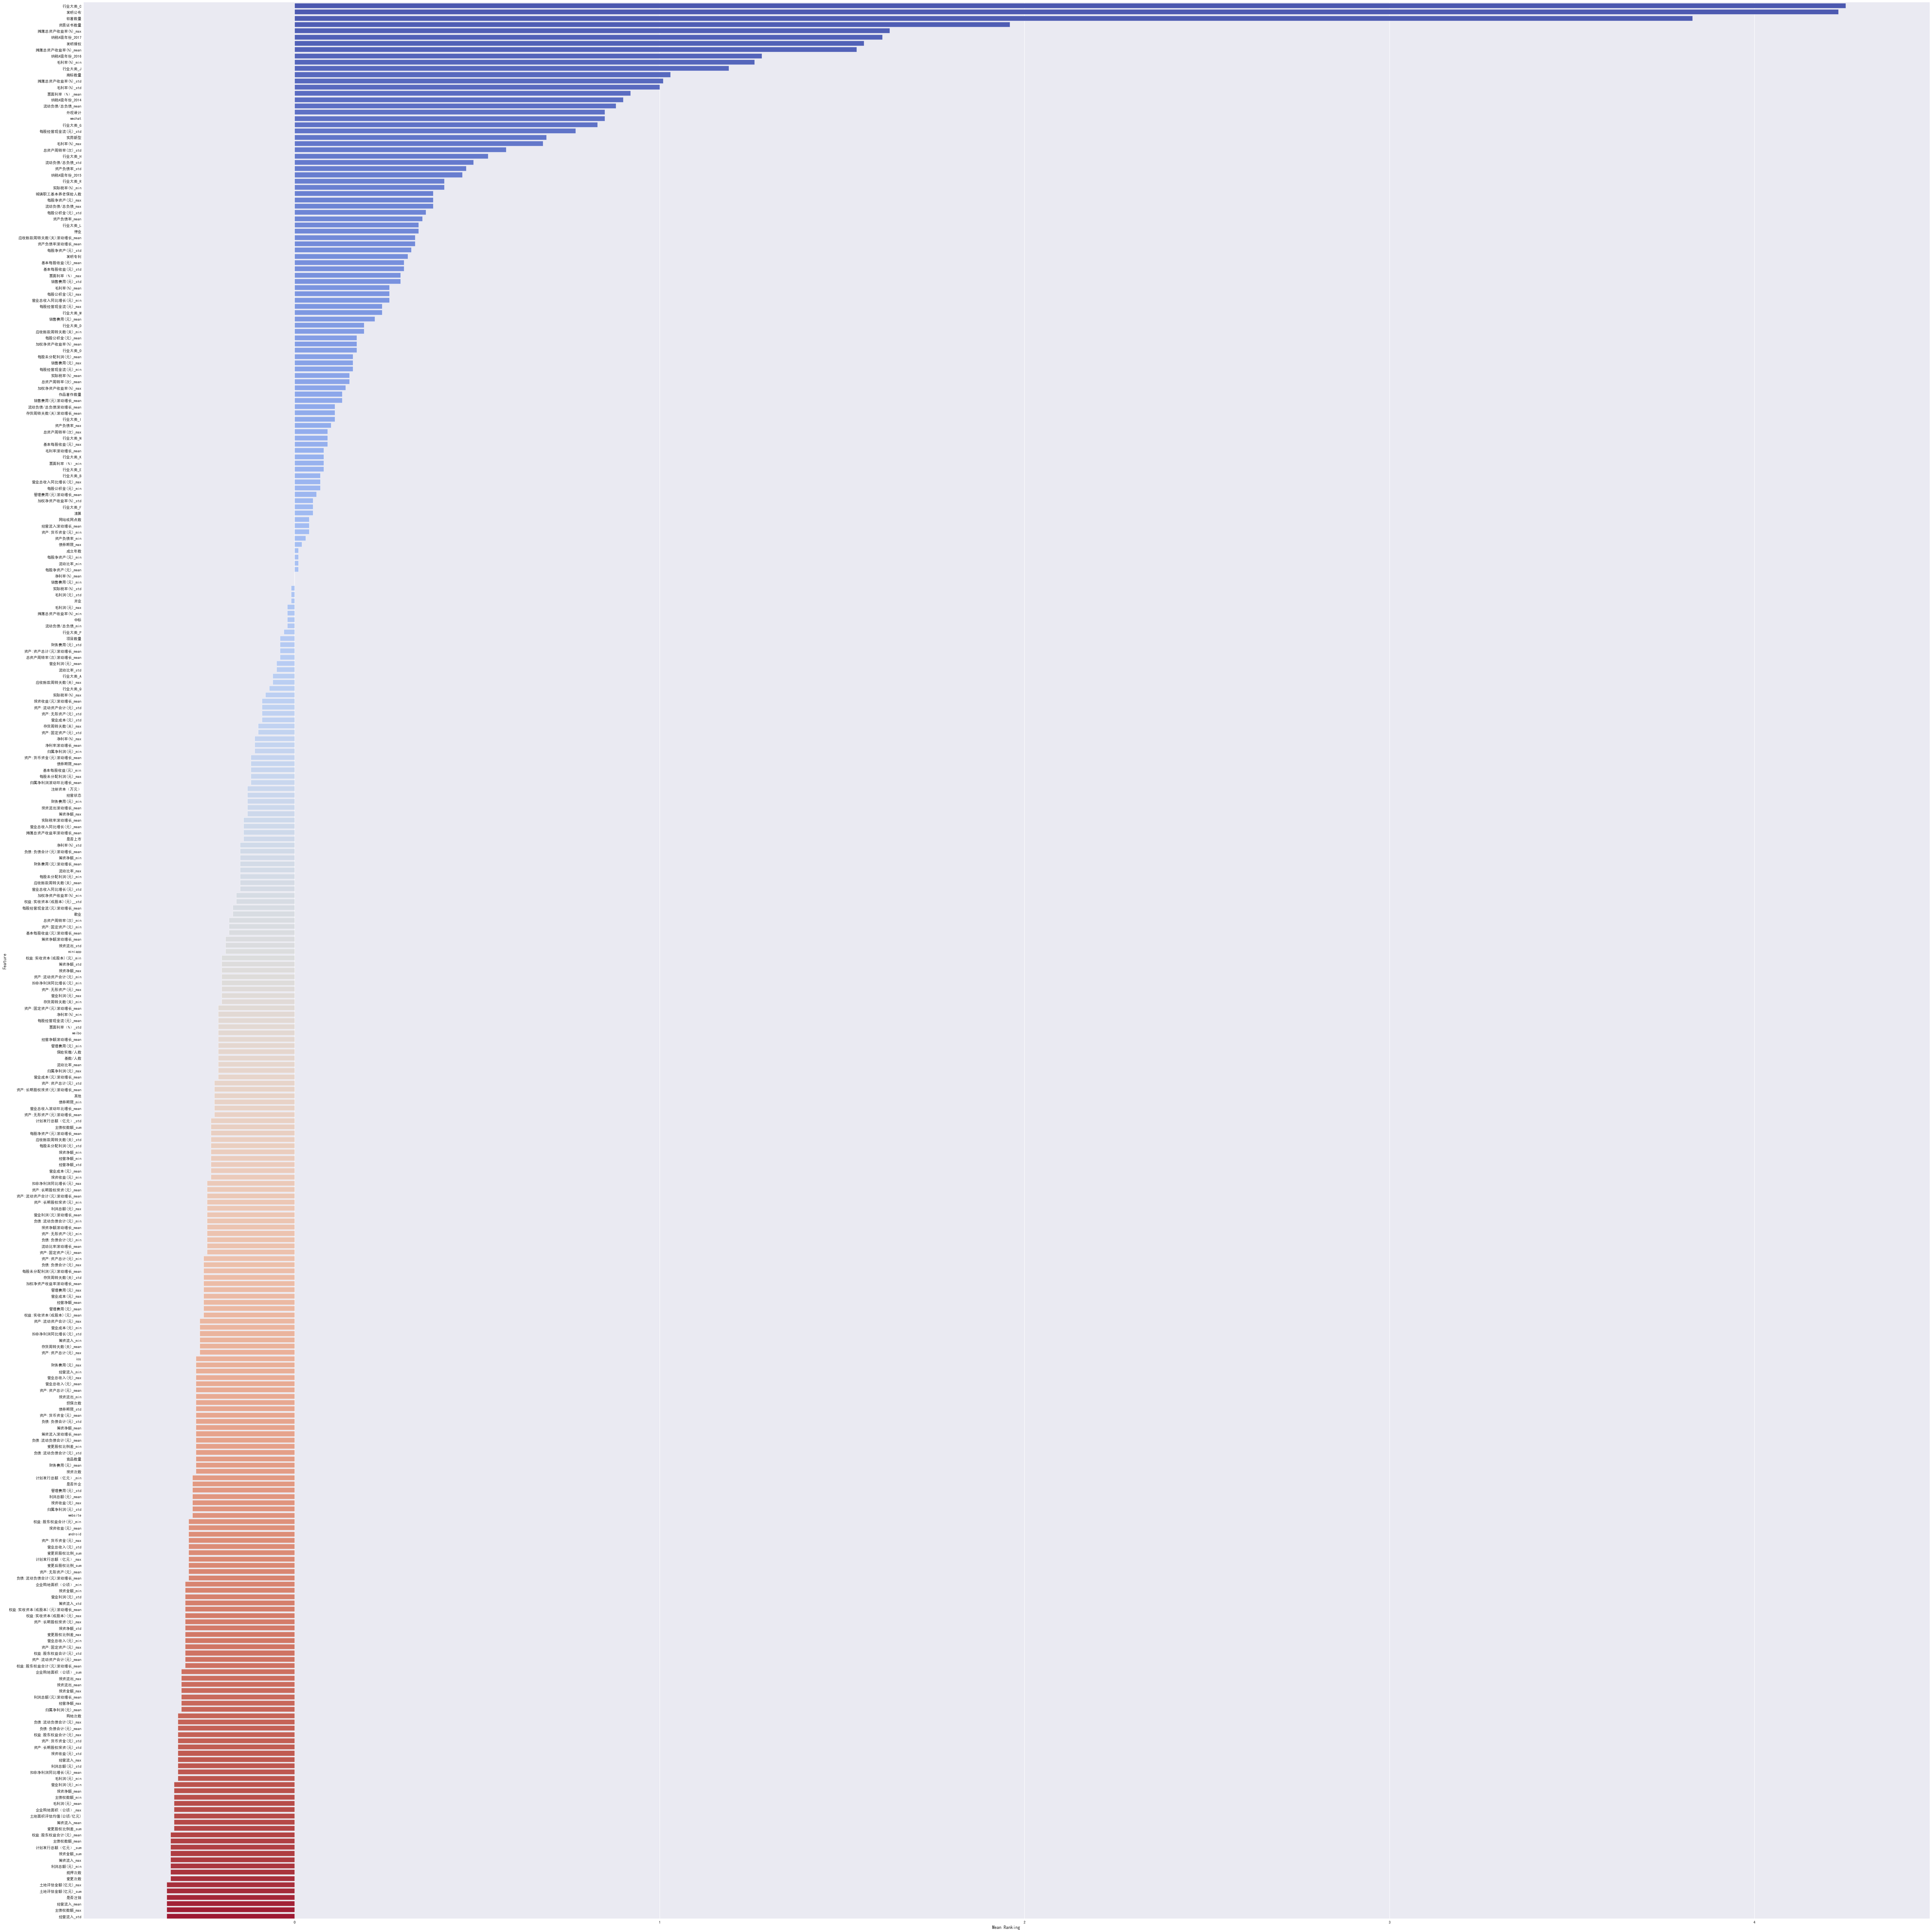

In [57]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns=['Feature', 'Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)
sns.factorplot(x="Mean Ranking", y="Feature", data=meanplot, kind="bar",
               size=70, aspect=1, palette='coolwarm')

In [58]:
# random forest predict
rf_ypre = rf.predict(xtest)
pre_rmse(rf_ypre)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


3.1505040351784466

In [59]:
# linear regression predict
lr_ypre = lr.predict(xtest)
pre_rmse(lr_ypre)

10.510290967248062

In [31]:
# ridge predict
ridge_ypre = ridge.predict(xtest)
pre_rmse(ridge_ypre)

10.628874492295644

In [32]:
# lasso predict
lasso_ypre = lasso.predict(xtest)
pre_rmse(lasso_ypre)

10.01468516324497

In [33]:
# decision tree regression
dtr_ypre = dtr.predict(xtest)
pre_rmse(dtr_ypre)

4.680140619278038

In [34]:
# adaboost regression
adar_ypre = adar.predict(xtest)
pre_rmse(adar_ypre)

3.358882938507175

In [60]:
# gbdt regression
gb_clf_ypre = gb_clf.predict(xtest)
pre_rmse(gb_clf_ypre)

5.804238898356027